In [2]:
import numpy as np
import pandas as pd
import math 
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
print(os.getcwd())
from scipy import stats
from scipy.stats import chi2_contingency #卡方檢定 & Crames'v
import statistics
from IPython.display import display  #在jupyter notebook 使用預覽畫面
import sklearn
print(sklearn.__version__)
#如果只有 0.19 記得要更新至 最新版本
%matplotlib inline
# 特徵選取會用到的函數
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

import pingouin as pg  # ANOVA 單因子及變數顯著性分析 (https://pingouin-stats.org/build/html/index.html)
import researchpy      #Cramér's V（克拉梅V係數）
plt.rcParams['font.family'] = 'Microsoft JhengHei' #顯示中文字(Windows)
#plt.rcParams['font.family'] = 'Heiti TC' #顯示中文字(Mac OS)


D:\Python3.9\AI數學馬拉松
1.5.1


In [2]:
hawkeye_data = pd.read_excel(r"D:\數據分析科\鷹眼\警示戶資料分析\SQL_警示戶.xlsx")

In [3]:
hawkeye_data['PBM_ACC_ID_NO'] = hawkeye_data['PBM_ACC_ID_NO'].astype(str)
hawkeye_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   交易日              354 non-null    datetime64[ns]
 1   PBM_ID_NO        354 non-null    object        
 2   PBM_ACC_ID_NO    354 non-null    object        
 3   行業別名稱            354 non-null    object        
 4   網銀狀態             354 non-null    object        
 5   薪轉戶註記            354 non-null    object        
 6   行員註記             354 non-null    object        
 7   警示戶註記            354 non-null    object        
 8   黑名單註記            354 non-null    object        
 9   是否進行KYC註記        354 non-null    object        
 10  拒往註記             354 non-null    object        
 11  GENDER           354 non-null    object        
 12  EMAIL            253 non-null    object        
 13  性質別_CHAR_CODE    354 non-null    object        
 14  管制性帳戶            354 non-null    object   

In [6]:
hawkeye_data_v2.loc[ hawkeye_data['年齡'] != 125, ~hawkeye_data.columns.str.contains('交易日|BIRTH_DATE')].describe()

,年齡,金融卡使用次數
count,350.000000,350.000000
mean,39.725714,76.854286
std,15.391330,129.104560
min,17.000000,0.000000
25%,27.000000,0.000000
50%,33.000000,40.000000
75%,51.000000,92.000000
max,75.000000,1020.000000


In [7]:
hawkeye_data_v2['GENDER'].value_counts()

GENDER
F    183
M    131
O     36
Name: count, dtype: int64

In [5]:
hawkeye_data_v2 = hawkeye_data.loc[ hawkeye_data['年齡'] != 125,:]

In [16]:
cards_count = hawkeye_data_v2['金融卡使用次數'].mean()
hawkeye_data_v2['金融卡使用次數'].median()

40.0

In [38]:
del ax

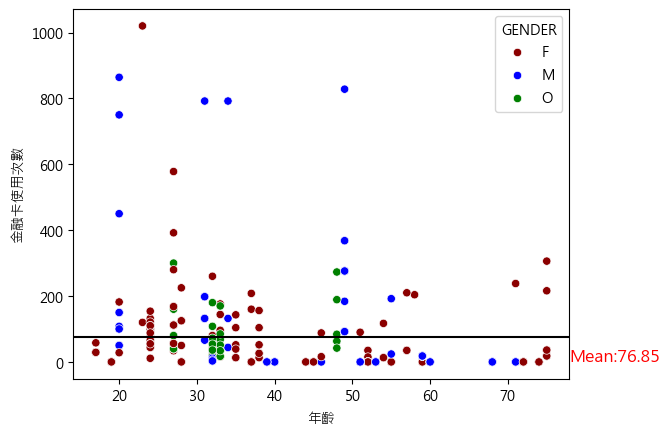

In [40]:
ax = sns.scatterplot(hawkeye_data_v2 , x = '年齡',y = '金融卡使用次數',hue= 'GENDER',palette = ['darkred','blue','green'])
ax.axhline(cards_count, color = 'black', linestyle = '-')
ax.text(cards_count+1, ax.get_xlim()[1]*0.05, f'Mean:{cards_count:.2f}',color = 'red',fontsize = 12)
plt.show()

In [ ]:
hawkeye_data_v2['']

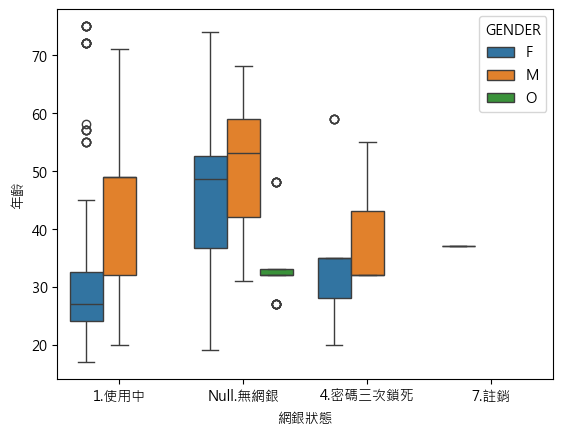

In [57]:
sns.boxplot(hawkeye_data_v2, x = '網銀狀態', y = '年齡',hue = 'GENDER')
plt.show()

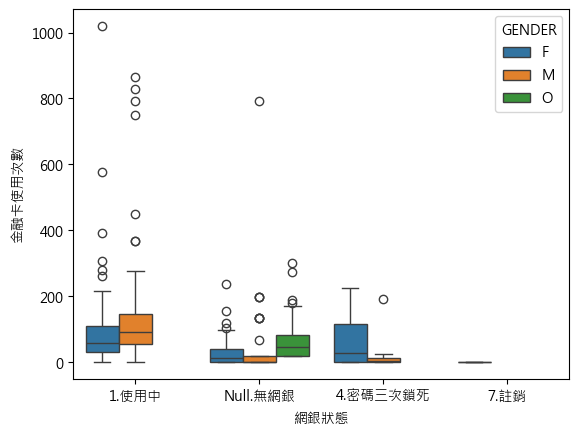

In [11]:
sns.boxplot(hawkeye_data_v2, x = '網銀狀態', y = '金融卡使用次數',hue = 'GENDER')
plt.show()

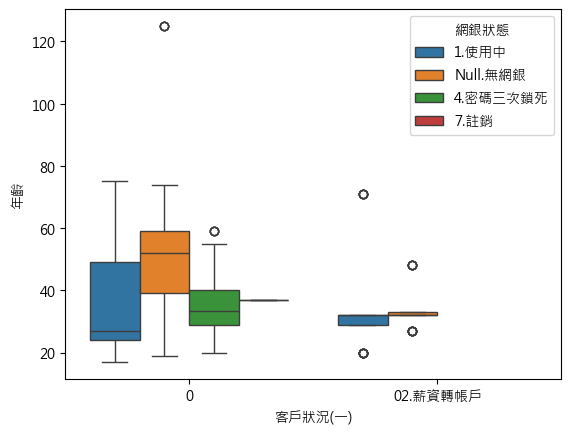

In [246]:
sns.boxplot(hawkeye_data, x = '客戶狀況(一)', y = '年齡',hue = '網銀狀態')
plt.savefig('網銀狀態與年齡關係.png',bbox_inches = 'tight')
plt.show()

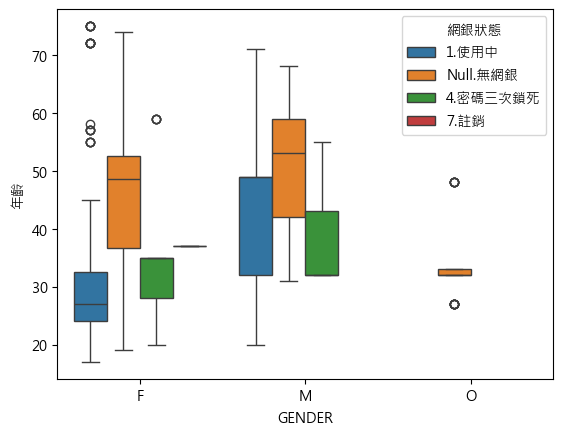

In [167]:
sns.boxplot(hawkeye_data_v2, x = 'GENDER', y = '年齡',hue = '網銀狀態')
plt.show()

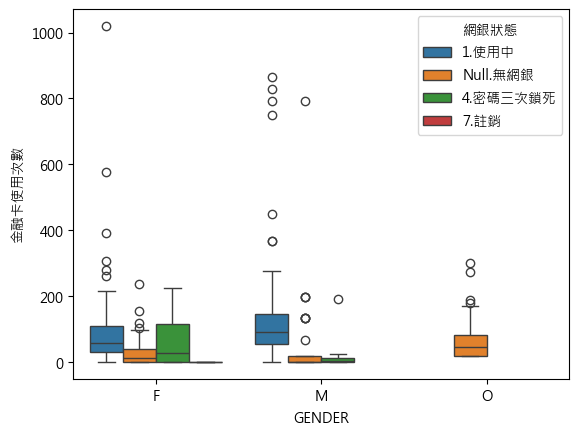

In [12]:
sns.boxplot(hawkeye_data_v2, x = 'GENDER', y = '金融卡使用次數',hue = '網銀狀態')
plt.show()

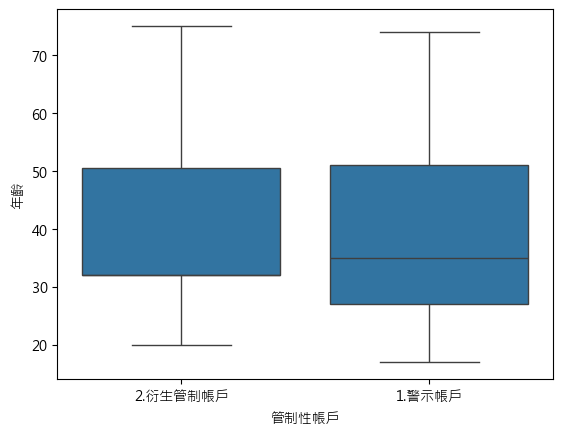

In [86]:
sns.boxplot(hawkeye_data_v2, x = '管制性帳戶', y = '年齡',hue = '')
plt.show()

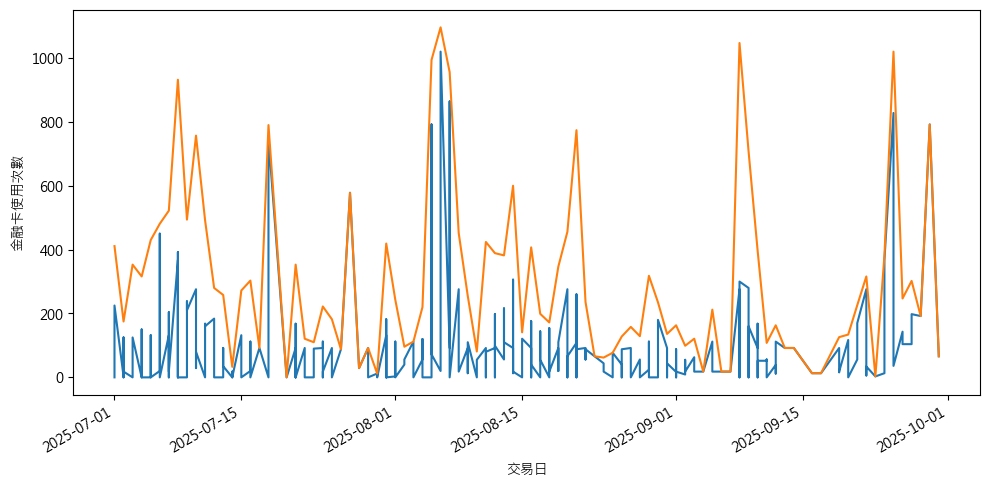

In [206]:
import matplotlib.dates as mdates
hawkeye_data.set_index('交易日')['金融卡使用次數'].plot(figsize = (10,5))
ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))  # 切日期分隔區間
plt.xlabel('交易日')
plt.ylabel('金融卡使用次數')
plt.tight_layout()
#plt.show()

# 依日期分組統計
daily_count = hawkeye_data.groupby('交易日')['金融卡使用次數'].sum()
ax.plot(daily_count.index,daily_count.values)
plt.show()

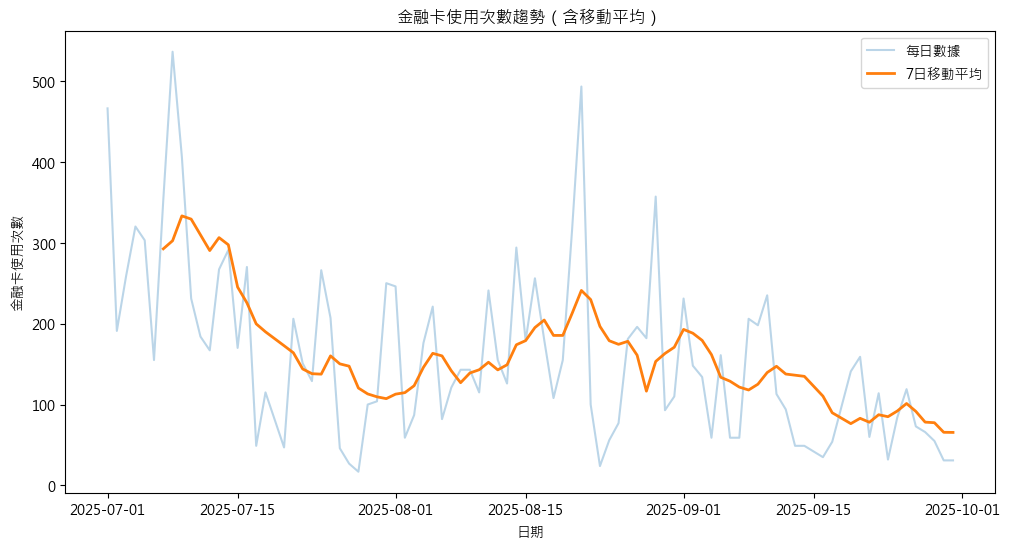

In [43]:
#7日平均移動圖
hawkeye_data_sorted = hawkeye_data.sort_values('交易日')
daily_sum = hawkeye_data_sorted.groupby('交易日')['年齡'].sum()
rolling_mean = daily_sum.rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(daily_sum.index, daily_sum.values, alpha=0.3, label='每日數據')
plt.plot(rolling_mean.index, rolling_mean.values, linewidth=2, label='7日移動平均')
plt.title('金融卡使用次數趨勢（含移動平均）')
plt.legend()
plt.xlabel('日期')
plt.ylabel('金融卡使用次數')
plt.savefig('近三個月時間序列圖.png',bbox_inches = 'tight')
plt.show()


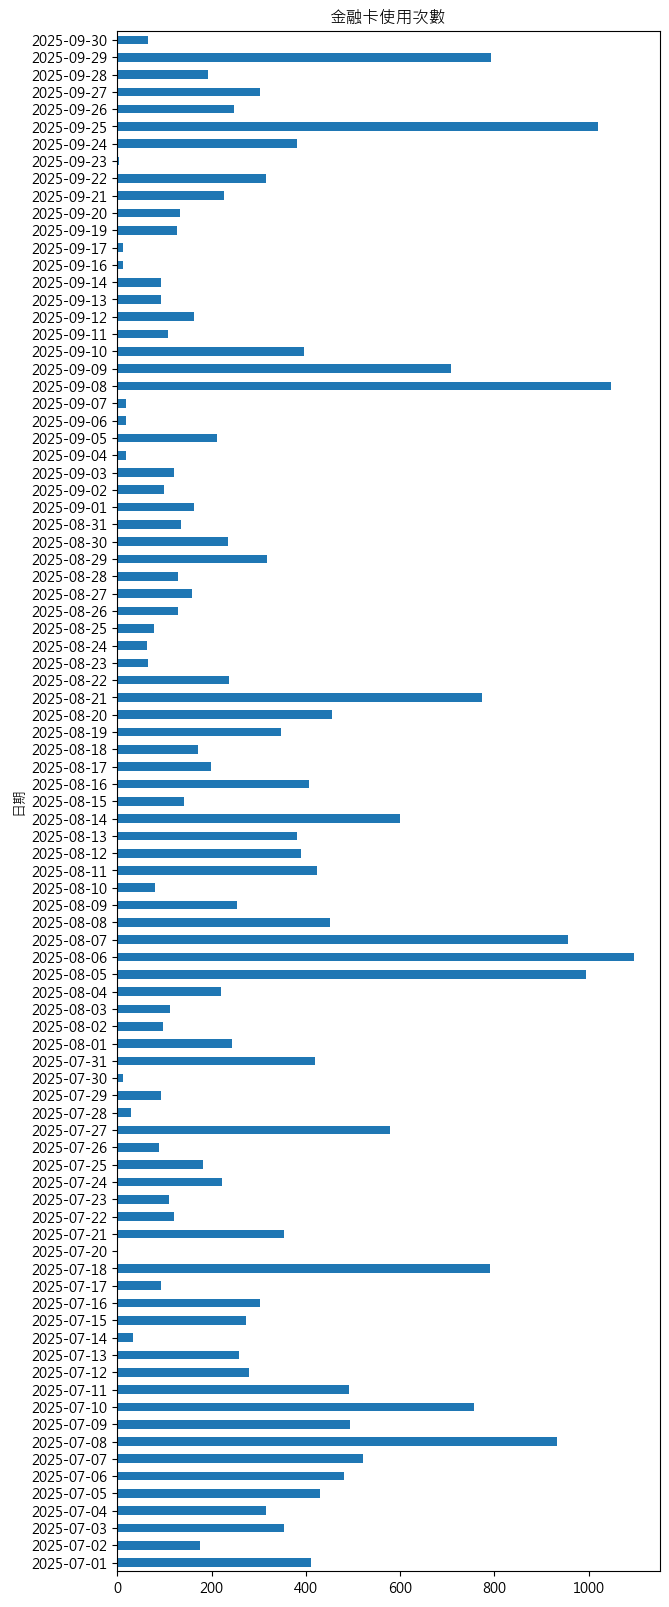

In [224]:
# 長條圖 按月份統計
hawkeye_data['每天'] = hawkeye_data['交易日'].dt.to_period('D')
monthly_stats = hawkeye_data.groupby('每天')['金融卡使用次數'].sum()
monthly_stats.plot(kind='barh', figsize=(7, 20))
plt.title('金融卡使用次數')
#plt.xticks(rotation=90)
plt.ylabel('日期')
plt.savefig('三個月每天金融卡使用次數.png',bbox_inches = 'tight')
plt.show()


In [201]:
pivot_table

月,7,8,9
星期,,,
0,867,602,582
1,1423,712,444
2,1100,720,507
3,1055,1090,291
4,826,1025,469
5,516,575,333
6,496,548,223


In [200]:
# #力圖：星期 vs 月份   建立日期相關欄位
hawkeye_data['年'] = hawkeye_data['交易日'].dt.year
hawkeye_data['月'] = hawkeye_data['交易日'].dt.month
hawkeye_data['星期'] = hawkeye_data['交易日'].dt.dayofweek
pivot_table = hawkeye_data.pivot_table(
values='年齡',
index='星期',
columns='月',
aggfunc='sum'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('不同星期和月份的年齡分布')
plt.show()



SyntaxError: '(' was never closed (4202120910.py, line 5)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8136 sha256=b8b9c8368a88836611a3bd2ceacb1d15d0bf2a4d510bbc3d9756a549e1f5490c
  Stored in directory: c:\users\b003087\appdata\local\pip\cache\wheels\f1\eb\af\79f8750a9f757aa0ccb6a0e217515abf3892f989345e98e50c
Successfully built calplot


findfont: Font family 'Helvetica' not found.


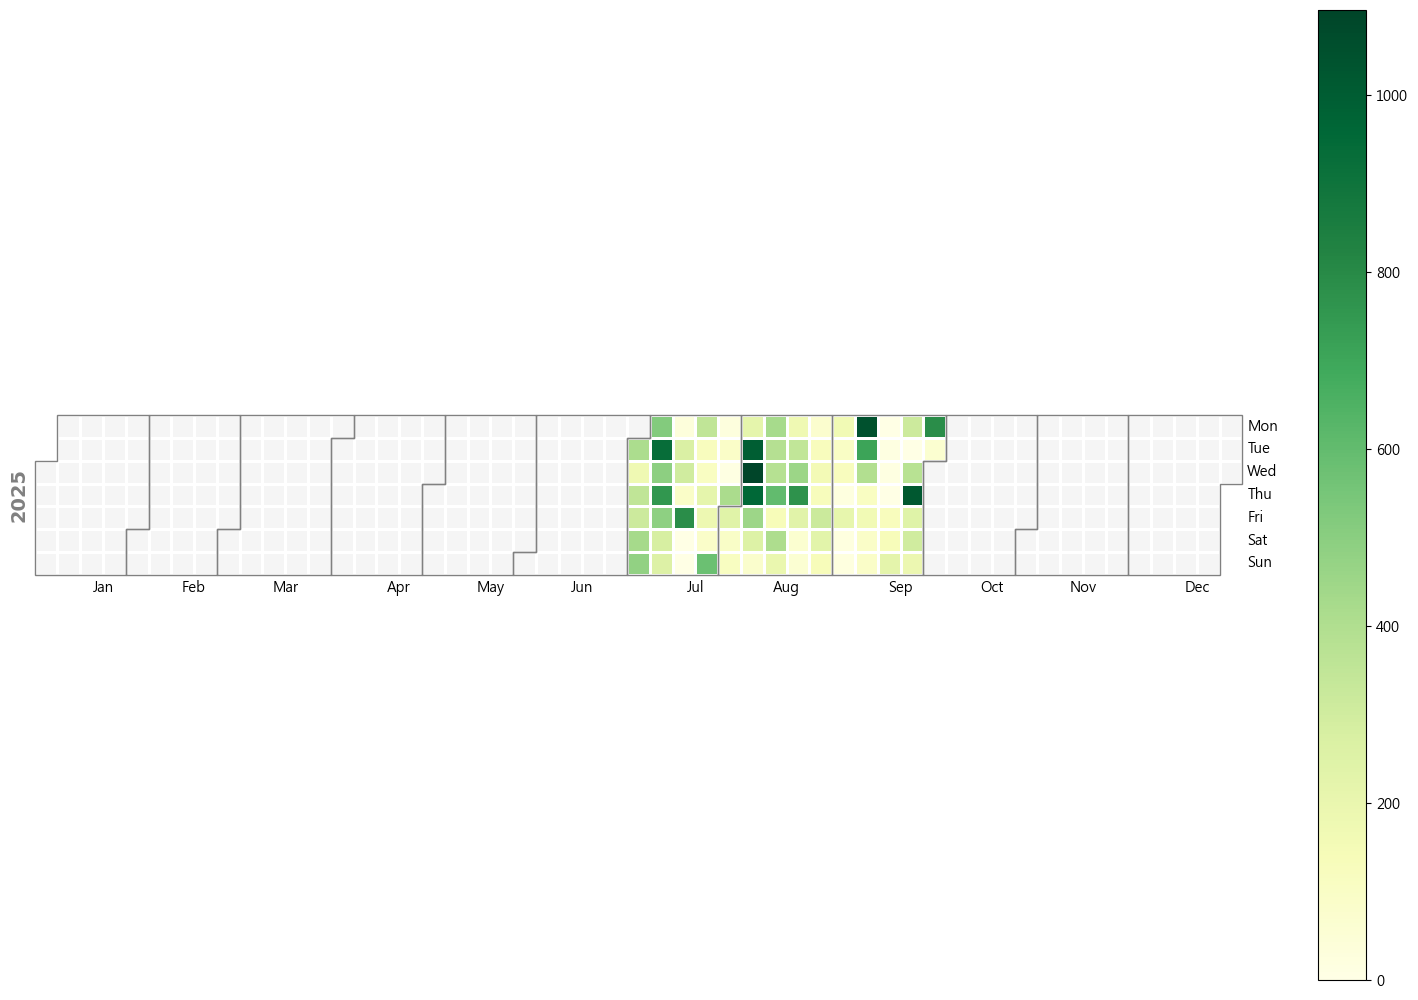

In [198]:
#!pip install calplot
import calplot

# 準備數據
daily_data = hawkeye_data.groupby('交易日')['金融卡使用次數'].sum()

# 繪製日曆熱力圖
calplot.calplot(daily_data, cmap='YlGn', figsize=(16, 10),
yearlabel_kws={'fontsize': 14})
plt.show()


In [168]:
hawkeye_data.shape

(354, 25)

In [46]:
print(hawkeye_data[hawkeye_data['客戶狀況(一)']=='02.薪資轉帳戶'].groupby(['金融卡狀況'])[['金融卡狀況']].size().reset_index(name = '個數'),'\n')
print(hawkeye_data[hawkeye_data['客戶狀況(一)']=='02.薪資轉帳戶'].groupby(['客戶狀態'])[['客戶狀態']].size().reset_index(name = '個數'))

        金融卡狀況   個數
0       0.未領用  195
1       1.已使用  800
2  2.已啟用未變更密碼  229
3        6.遺失   25
4        7.註銷  432 

     客戶狀態    個數
0  00.正常戶   178
1  02.止扣戶  1055
2  05.結清戶   448


In [165]:
#敘述性統計
print(hawkeye_data_v2['客戶狀況(一)'].value_counts(),'\n')
print(hawkeye_data['EMAIL'].isna().sum(),'\n')
print(hawkeye_data['客戶狀況(一)'].value_counts(),'\n')
print(hawkeye_data['網銀狀態'].value_counts(),'\n')
print(hawkeye_data['止扣原因'].value_counts(),'\n')
print(hawkeye_data['GENDER'].value_counts(),'\n')

客戶狀況(一)
0           278
02.薪資轉帳戶     72
Name: count, dtype: int64 

101 

客戶狀況(一)
0           282
02.薪資轉帳戶     72
Name: count, dtype: int64 

網銀狀態
1.使用中       185
Null.無網銀    130
4.密碼三次鎖死     34
7.註銷          5
Name: count, dtype: int64 

止扣原因
04.管制帳戶             255
0                    90
12.04管制帳戶+08死亡凍結      6
20.04管制帳戶+16法院扣押      3
Name: count, dtype: int64 

GENDER
F    184
M    134
O     36
Name: count, dtype: int64 



In [163]:
for i, col in enumerate(hawkeye_data.columns):
    print(f'{i}:{col}')

0:交易日
1:PBM_ID_NO
2:PBM_ACC_ID_NO
3:行業別名稱
4:網銀狀態
5:薪轉戶註記
6:行員註記
7:警示戶註記
8:黑名單註記
9:是否進行KYC註記
10:拒往註記
11:GENDER
12:EMAIL
13:性質別_CHAR_CODE
14:管制性帳戶
15:客戶狀態
16:客戶狀況(一)
17:金融卡轉帳狀況
18:止扣原因
19:金融卡狀況
20:性質別_CHAR_CODE.1
21:利率別
22:BIRTH_DATE
23:年齡
24:金融卡使用次數


In [54]:
hawkeye_data[hawkeye_data['客戶狀況(一)']=='02.薪資轉帳戶'].groupby(['EMAIL'])[['EMAIL']].count()

,EMAIL
EMAIL,
0960618@gmail.com,8
314kxun@gmail.com,12
Ashleetsai.b@gmail.com,2
E22180111@gmail.com,1
NGOCDON.281100@GMAIL.COM,6
...,...
wu81952176@ymail.com,9
wu8366@yahoo.com.tw,5
x23235623@gmail.com,37


In [297]:
hawkeye_data_age = hawkeye_data_age.groupby('年齡')[['客戶狀況(一)']].value_counts().unstack().reset_index()
hawkeye_data_age.to_csv('hawkeye_data_age.csv', encoding = 'utf-8-sig')

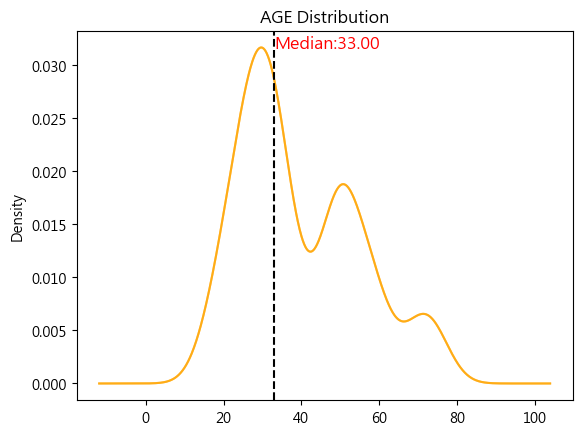

In [59]:
ax = hawkeye_data_v2['年齡'].plot(kind = 'density',  
                             color = 'orange',
                           title = 'AGE Distribution', alpha = 0.7)
median_age = hawkeye_data_v2['年齡'].median()
mean_age = hawkeye_data_v2['年齡'].mean()
ax.axvline(median_age, color = 'black', linestyle = '--')
#ax.axvline(mean_age, color = 'green', linestyle = '--')
ax.text(median_age, ax.get_ylim()[1]*0.95, f'Median:{median_age:.2f}',color = 'red',fontsize = 12)
plt.show()

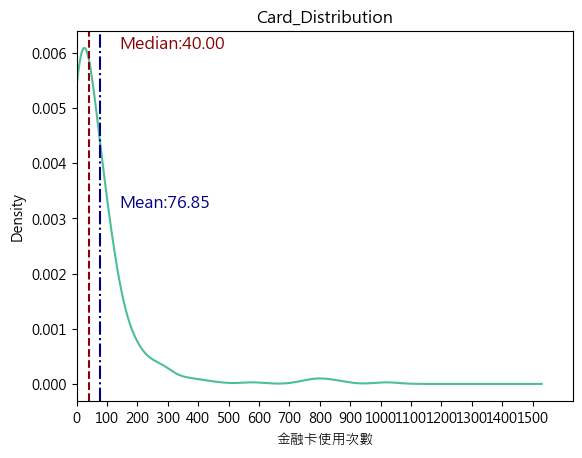

In [138]:
ax = hawkeye_data_v2['金融卡使用次數'].plot(kind = 'density',  
                             color = '#00A36C',
                           title = 'Card_Distribution', alpha = 0.7)
median_card = hawkeye_data_v2['金融卡使用次數'].median()
mean_card = hawkeye_data_v2['金融卡使用次數'].mean()
ax.axvline(median_card, color = 'darkred', linestyle = '--')
ax.axvline(mean_card, color = 'darkblue', linestyle = '-.')
ax.set_xlim(0,None) # 設定座標軸從0開始
ax.set_xticks(np.arange(0,1600,100))
ax.text(median_card+100,ax.get_ylim()[1]*0.95, f'Median:{median_age:.2f}',color = 'darkred',fontsize = 12)
ax.text(mean_card+65, ax.get_ylim()[1]*0.5, f'Mean:{mean_age:.2f}',color = 'darkblue',fontsize = 12)
ax.set_xlabel('金融卡使用次數')
plt.show()

In [105]:
# q_high = hawkeye_data['年齡'].quantile(q = 0.65)
# q_low = hawkeye_data['年齡'].quantile(q = 0.001)
# hawkeye_data_age = hawkeye_data[(hawkeye_data['年齡']<q_high) & (hawkeye_data['年齡']>q_low)]
# hawkeye_data_age['年齡'].describe()

count    6171.000000
mean       53.767785
std        22.087135
min        18.000000
25%        35.000000
50%        51.000000
75%        69.000000
max       102.000000
Name: 年齡, dtype: float64

In [62]:
hawkeye_data_v2.rename(columns = {'PBM_ID_NO':'身分證','PBM_ACC_ID_NO':'帳號'},inplace = True)

C:\Users\b003087\AppData\Local\Temp\ipykernel_18476\1964643740.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hawkeye_data_v2.rename(columns = {'PBM_ID_NO':'身分證','PBM_ACC_ID_NO':'帳號'},inplace = True)


In [65]:
hawkeye_data_v2.groupby('身分證')[['網銀狀態']].value_counts().unstack()

網銀狀態,1.使用中,4.密碼三次鎖死,7.註銷,Null.無網銀
身分證,,,,
A227412570,NaN,6.0,NaN,NaN
D120272257,NaN,2.0,NaN,NaN
E102334371,NaN,NaN,NaN,6.0
E122137207,NaN,NaN,NaN,6.0
E122194239,31.0,NaN,NaN,NaN
E123596424,NaN,2.0,NaN,NaN
E124526686,NaN,8.0,NaN,NaN
E124602592,6.0,NaN,NaN,NaN
E124784679,NaN,NaN,NaN,9.0


In [269]:
hawkeye_data_cardsist.to_csv('hawkeye_data_cardsist.csv', encoding = 'utf-8-sig')

In [160]:
hawkeye_data_age.groupby(['止扣原因','金融卡轉帳狀況'])['客戶狀況(一)'].size().reset_index()

,止扣原因,金融卡轉帳狀況,客戶狀況(一)
0,0,0.非約定轉帳,1486
1,0,1.兩者皆有,434
2,0,2.約定轉帳,4
3,0,3.皆無轉帳功能,903
4,04.管制帳戶,0.非約定轉帳,2106
5,04.管制帳戶,1.兩者皆有,343
6,04.管制帳戶,3.皆無轉帳功能,708
7,06.02存摺掛失+04管制帳戶,0.非約定轉帳,21
8,06.02存摺掛失+04管制帳戶,3.皆無轉帳功能,8
9,12.04管制帳戶+08死亡凍結,0.非約定轉帳,13


In [156]:
print(hawkeye_data_age['身分證'].nunique())
hawkeye_data_age['帳號'].nunique()

1525


1581

In [174]:
hawkeye_data_age[hawkeye_data_age['客戶狀況(一)'] == '02.薪資轉帳戶'].groupby(['金融卡轉帳狀況'])['身分證'].size()

金融卡轉帳狀況
0.非約定轉帳     910
1.兩者皆有      141
3.皆無轉帳功能    328
Name: 身分證, dtype: int64

In [178]:
hawkeye_data_age[hawkeye_data_age['客戶狀況(一)'] == '02.薪資轉帳戶'].groupby(['金融卡轉帳狀況'])['身分證'].size().reset_index()

,金融卡轉帳狀況,身分證
0,0.非約定轉帳,910
1,1.兩者皆有,141
2,3.皆無轉帳功能,328


In [172]:
hawkeye_data_age.groupby(['客戶狀況(一)','金融卡狀況'])['身分證'].count().reset_index()

,客戶狀況(一),金融卡狀況,身分證
0,0,0.未領用,687
1,0,1.已使用,1533
2,0,2.已啟用未變更密碼,655
3,0,4.密碼錯誤三次鎖死,10
4,0,6.遺失,51
5,0,7.註銷,1671
6,0,9.申請,172
7,01.重要存款戶,1.已使用,13
8,02.薪資轉帳戶,0.未領用,176
9,02.薪資轉帳戶,1.已使用,642
